# S3: AirBnb NYC 2024 Listings
by: Tam Trinh           
April 6, 2025         

<a id="0"></a> <br>
## Table of Contents  

- [Set-up and Load Data](#1)
- [XGBoost Model Tuning](#2)
- [Stylized Visualizations](#3)   
- [Conclusion](#4)

<a id="1"></a>
## Set-up and Load Data

In [1]:
# imports for functionality and plotting
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# optional imports
import warnings
import pickle

# imports for preprocessing
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

# imports for modeling
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from tempfile import mkdtemp
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor

from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.inspection import permutation_importance

In [2]:
# ignore warnings
from warnings import filterwarnings
warnings.filterwarnings('ignore')

In [ ]:
# # load datasets

# airbnb_df = pd.read_csv("../data/new_york_listings_2024.csv")

# aircopy = pd.read_csv("../data/eda_airbnb.csv")

# cleaned_airbnb = pd.read_csv("../data/cleaned_airbnb.csv")

In [5]:
cleaned_limit500 = pd.read_csv("cleaned_limit500_Copy.csv")

***

<a id="2"></a> <br>
## XGBoost Model Tuning

#### Train/test split

In [7]:
# split the data into train and test sets
X = cleaned_limit500.loc[:, cleaned_limit500.columns != "price"]
y = cleaned_limit500["price"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

#### Create functions for modeling interpretation

In [8]:
def score_r2_rmse_mae(model):
    """A function that prints the R^2 scores for the Train and Test set, RMSE, and MAE scores.
    """

    # print train and test R^2 scores
    print(f"Train score: {model.score(X_train, y_train)}")
    print(f"Test score: {model.score(X_test, y_test)}")

    # make array of y_pred
    y_pred = model.predict(X_test)

    # Calculate RMSE
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    print("RMSE:", rmse)

    # Calculate MAE
    mae = mean_absolute_error(y_test, y_pred)
    print("MAE:", mae)

#### Fit the gridsearch best fit model

In [9]:
estimators = [("scaler", StandardScaler()),
              ('xgb', XGBRegressor())]

cachedir = mkdtemp()
pipe = Pipeline(estimators, memory=cachedir)

params= {
    "scaler": ['passthrough', StandardScaler()],
    "xgb__n_estimators": [100, 200],
    "xgb__max_depth": [3, 5, 7],
    "xgb__learning_rate": [0.01, 0.1, 0.2],
    "xgb__subsample": [0.8, 1.0],
}

grid_search = GridSearchCV(pipe, param_grid=params, cv=5)


In [10]:
xgb_best = grid_search.fit(X_train, y_train)

In [11]:
xgb_best.best_estimator_


Pipeline(memory='/var/folders/s2/vdwvjj2j24d4tg5yz10ycr080000gn/T/tmpfwdeyk3h',
         steps=[('scaler', 'passthrough'),
                ('xgb',
                 XGBRegressor(base_score=None, booster=None, callbacks=None,
                              colsample_bylevel=None, colsample_bynode=None,
                              colsample_bytree=None, early_stopping_rounds=None,
                              enable_categorical=False, eval_metric=None,
                              feature_types=None, gamma=None, gpu_id=None,
                              grow_policy=None, importance_type=None,
                              interaction_constraints=None, learning_rate=0.1,
                              max_bin=None, max_cat_threshold=None,
                              max_cat_to_onehot=None, max_delta_step=None,
                              max_depth=7, max_leaves=None,
                              min_child_weight=None, missing=nan,
                              monotone_constraints=None, n_estimators=200,
                              n_jobs=None, num_parallel_tree=None,
                              predictor=None, random_state=None, ...))])

In [12]:
print(f"The best fit scaler is: {xgb_best.best_estimator_.named_steps['scaler']}")
print(f"The best fit model is: {xgb_best.best_estimator_.named_steps['xgb']}")

The best fit scaler is: passthrough
The best fit model is: XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.1, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=7, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=200, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=None, ...)


In [13]:
# find scores
score_r2_rmse_mae(xgb_best)

Train score: 0.8373479996794715
Test score: 0.547847714275729
RMSE: 61.367670855910696
MAE: 42.18971173166931


In [14]:
# compare y_pred to y_true

# predict y_pred values
y_pred = xgb_best.predict(X_test)

# add to df
y_truevspred = pd.DataFrame({"True_y": y_test, "Pred_y": y_pred, "Diff": (y_test - y_pred)})

# display
y_truevspred

,True_y,Pred_y,Diff
15472,357.0,193.558472,163.441528
1242,85.0,133.938736,-48.938736
2311,190.0,247.983490,-57.983490
9112,286.0,334.203247,-48.203247
11832,180.0,186.351440,-6.351440
...,...,...,...
12538,150.0,142.972900,7.027100
14497,229.0,224.593689,4.406311
8989,100.0,132.487289,-32.487289
3144,214.0,166.392059,47.607941


In [39]:
x_sample = X_test.iloc[0]
y_sample = y_test.iloc[0]


x_sample_df = x_sample.to_frame().T

x_sample_df
# xgb_best.predict(x_sample)

,latitude,longitude,minimum_nights,number_of_reviews,reviews_per_month,calculated_host_listings_count,availability_365,number_of_reviews_ltm,bedrooms,beds,...,ratings_3.0,ratings_4.0,ratings_4.2,ratings_4.4,ratings_4.6,ratings_4.8,ratings_5,ratings_New,ratings_No rating,ratings_less3
15472,40.73356,-73.98684,30.0,20.0,0.81,1.0,90.0,1.0,3.0,3.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0


In [40]:
new_input = pd.DataFrame([{
    'latitude': 40.7128,
    'longitude': -74.0060,
    'minimum_nights': 3,
    'number_of_reviews': 42,
    'reviews_per_month': 1.2,
    'calculated_host_listings_count': 2,
    'availability_365': 180,
    'number_of_reviews_ltm': 10,
    'bedrooms': 1,
    'beds': 1,
    'baths': 1,
    'month': 5,
    'neighborhood_avgprice': 150,
    'last_review_month': 4,
    'last_review_year': 2024,
    'neighgroup_Bronx': 0,
    'neighgroup_Brooklyn': 0,
    'neighgroup_Manhattan': 1,
    'neighgroup_Queens': 0,
    'neighgroup_Staten Island': 0,
    'roomtype_Entire home/apt': 1,
    'roomtype_Hotel room': 0,
    'roomtype_Private room': 0,
    'roomtype_Shared room': 0,
    'license_Exempt': 0,
    'license_Has License': 1,
    'license_No License': 0,
    'ratings_3.0': 0,
    'ratings_4.0': 0,
    'ratings_4.2': 0,
    'ratings_4.4': 0,
    'ratings_4.6': 0,
    'ratings_4.8': 1,
    'ratings_5': 0,
    'ratings_New': 0,
    'ratings_No rating': 0,
    'ratings_less3': 0,
}])

# Predict the price
predicted_price = xgb_best.predict(x_sample_df)
print(f"Predicted Price: ${predicted_price[0]:.2f}")

Predicted Price: $193.56


In [37]:
x_sample_df

,15472
latitude,40.73356
longitude,-73.98684
minimum_nights,30.00000
number_of_reviews,20.00000
reviews_per_month,0.81000
calculated_host_listings_count,1.00000
availability_365,90.00000
number_of_reviews_ltm,1.00000
bedrooms,3.00000
beds,3.00000


#### Feature Importance

In [39]:
xgb_model = xgb_best.best_estimator_.named_steps["xgb"]

importances = xgb_model.feature_importances_

feature_importances = pd.Series(importances, index=X_test.columns)

feature_importances.sort_values(ascending=False)

roomtype_Entire home/apt          0.293597
license_No License                0.207005
baths                             0.095551
bedrooms                          0.038394
beds                              0.022434
neighborhood_avgprice             0.022041
license_Exempt                    0.021550
calculated_host_listings_count    0.016443
roomtype_Private room             0.016219
ratings_No rating                 0.015547
neighgroup_Manhattan              0.015365
ratings_5                         0.015316
minimum_nights                    0.014582
roomtype_Hotel room               0.012880
ratings_4.8                       0.011460
longitude                         0.011009
ratings_less3                     0.010710
reviews_per_month                 0.010396
ratings_4.0                       0.010384
neighgroup_Queens                 0.010235
ratings_4.4                       0.010145
availability_365                  0.009711
ratings_3.0                       0.009677
neighgroup_

In [40]:
# alternative booster importance
booster = xgb_model.get_booster()
importance_dict = booster.get_score(importance_type='cover')  

# display
importance_df = pd.DataFrame.from_dict(importance_dict, orient='index', columns=['Importance'])
importance_df = importance_df.sort_values(by='Importance', ascending=False)
importance_df

,Importance
ratings_3.0,5693.285645
license_No License,4936.702148
ratings_New,3037.846191
ratings_4.0,2536.906982
roomtype_Shared room,2518.547607
license_Has License,2211.718018
ratings_4.8,1719.431763
ratings_less3,1660.199951
roomtype_Entire home/apt,1626.761230
last_review_year,1533.383545


#### Plots of predicted vs actual

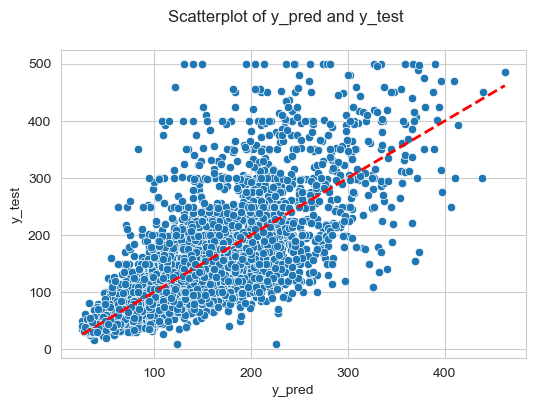

In [41]:
# scatterplot

plt.figure(figsize=(6,4))
ax = sns.scatterplot(x=y_pred, y=y_test)
plt.suptitle("Scatterplot of y_pred and y_test")
plt.xlabel("y_pred")
plt.ylabel("y_test")

x_vals = np.linspace(y_pred.min(), y_pred.max(), 100)
ax.plot(x_vals, x_vals, color='red', linestyle='--', linewidth=2) 

plt.show()


#### Pickle and save model

In [42]:
pickle.dump(xgb_best, open("../models/xgb_best.pkl","wb"))

In [42]:
# Save it to a file
import joblib

joblib.dump(xgb_best, "xgb_pipeline.pkl")

['xgb_pipeline.pkl']

<a id="3"></a>
## Stylized Visualizations

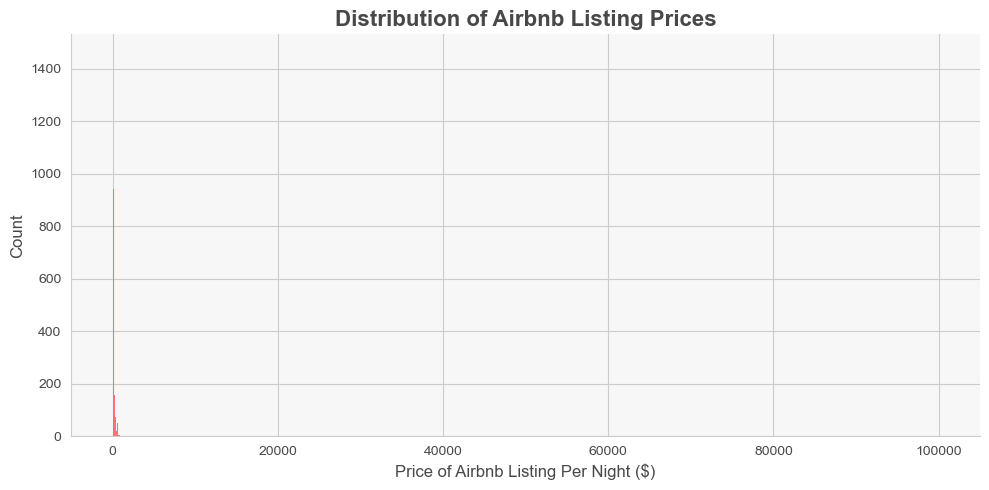

In [10]:
# Airbnb brand color
airbnb_red = "#FF5A5F"
background_gray = "#F7F7F7"
text_gray = "#484848"

# Styled histogram
plt.figure(figsize=(10, 5))
sns.set_style("whitegrid")

sns.histplot(
    data=aircopy,
    x="price",
    #bins=100,
    color=airbnb_red,
    edgecolor='white',
    alpha=0.85
)

# Title and axis styling
plt.title("Distribution of Airbnb Listing Prices", fontsize=16, fontweight='bold', color=text_gray)
plt.xlabel("Price of Airbnb Listing Per Night ($)", fontsize=12, color=text_gray)
plt.ylabel("Count", fontsize=12, color=text_gray)
plt.xticks(fontsize=10, color=text_gray)
plt.yticks(fontsize=10, color=text_gray)

# Background
plt.gca().set_facecolor(background_gray)
plt.gcf().set_facecolor('white')
sns.despine()

# Save
plt.tight_layout()
plt.savefig("../plots/pricenolimit_styled.png", dpi=300)
plt.show()

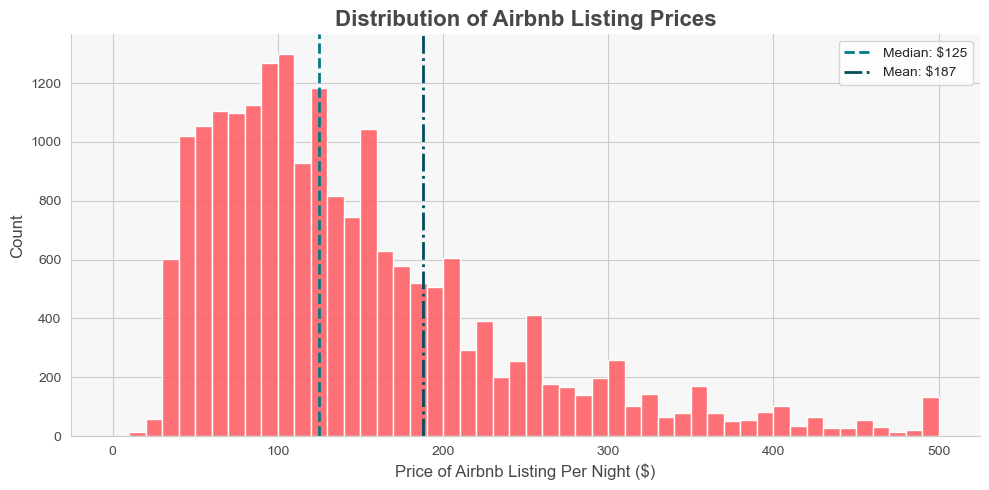

In [13]:
# Airbnb brand color
airbnb_red = "#FF5A5F"
airbnb_teal = "#007A87"
background_gray = "#F7F7F7"
text_gray = "#484848"

# Calculate median and mean from the full dataset
median_price = aircopy["price"].median()
mean_price = aircopy["price"].mean()

# Plot setup (same as before)
plt.figure(figsize=(10, 5))
sns.set_style("whitegrid")

sns.histplot(
    data=aircopy,
    x="price",
    binrange=(0, 500),
    bins=50,
    color=airbnb_red,
    edgecolor='white',
    alpha=0.85
)

# Median line
plt.axvline(
    median_price,
    color=airbnb_teal,
    linestyle="--",
    linewidth=2,
    label=f"Median: ${int(median_price)}"
)

# Mean line
plt.axvline(
    mean_price,
    color="#004E5A",  # Darker teal for contrast
    linestyle="-.",
    linewidth=2,
    label=f"Mean: ${int(mean_price)}"
)

plt.legend()

# Titles and labels
plt.title("Distribution of Airbnb Listing Prices", fontsize=16, fontweight='bold', color=text_gray)
plt.xlabel("Price of Airbnb Listing Per Night ($)", fontsize=12, color=text_gray)
plt.ylabel("Count", fontsize=12, color=text_gray)
plt.xticks(fontsize=10, color=text_gray)
plt.yticks(fontsize=10, color=text_gray)

# Airbnb-style background
plt.gca().set_facecolor(background_gray)
plt.gcf().set_facecolor('white')
sns.despine()

# Save and show
plt.tight_layout()
plt.savefig("../plots/pricelimit500_styled.png", dpi=300)
plt.show()


#### Top 10 NYC neighbouhoods by listing count

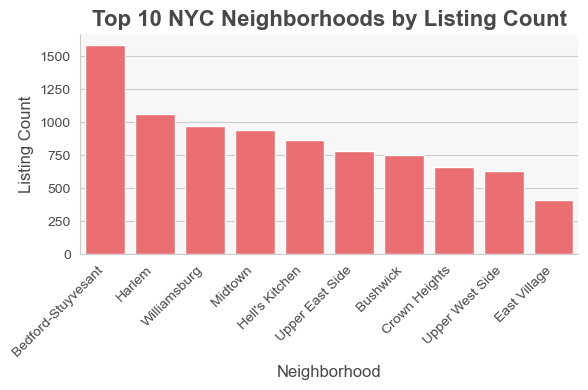

In [99]:
# Airbnb red
airbnb_red = '#FF5A5F'

# Get top 10 neighborhoods by listing count
top10_neighborhoods = aircopy["neighbourhood"].value_counts().nlargest(10)
top10_names = top10_neighborhoods.index
filtered_neigh_df = aircopy[aircopy["neighbourhood"].isin(top10_names)]

# Plot
plt.figure(figsize=(6, 4))
sns.set_style("whitegrid")

sns.countplot(
    data=filtered_neigh_df,
    x="neighbourhood",
    order=top10_names,  # Order bars by top 10 count
    color=airbnb_red
)

# Styling
plt.title("Top 10 NYC Neighborhoods by Listing Count", fontsize=16, fontweight='bold', color='#484848')
plt.xlabel("Neighborhood", fontsize=12, color='#484848')
plt.ylabel("Listing Count", fontsize=12, color='#484848')
plt.xticks(rotation=45, ha='right', fontsize=10, color='#484848')
plt.yticks(fontsize=10, color='#484848')
sns.despine()

# Background
plt.gca().set_facecolor('#F7F7F7')
plt.gcf().set_facecolor('white')

# Save
plt.tight_layout()
plt.savefig("../plots/top10_airbnb_neighborhoods.png", dpi=300)

plt.show()

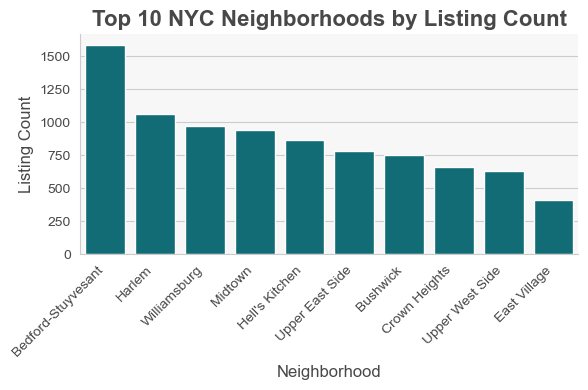

In [109]:
# Airbnb teal and design elements
airbnb_teal = '#007A87'
background_gray = '#F7F7F7'
text_gray = '#484848'

# Get top 10 neighborhoods by listing count
top10_neighborhoods = aircopy["neighbourhood"].value_counts().nlargest(10)
top10_names = top10_neighborhoods.index
filtered_neigh_df = aircopy[aircopy["neighbourhood"].isin(top10_names)]

# Plot
plt.figure(figsize=(6, 4))  
sns.set_style("whitegrid")

sns.countplot(
    data=filtered_neigh_df,
    x="neighbourhood",
    order=top10_names,
    color=airbnb_teal  # switched from red to teal
)

# Titles and labels
plt.title("Top 10 NYC Neighborhoods by Listing Count", fontsize=16, fontweight='bold', color=text_gray)
plt.xlabel("Neighborhood", fontsize=12, color=text_gray)
plt.ylabel("Listing Count", fontsize=12, color=text_gray)
plt.xticks(rotation=45, ha='right', fontsize=10, color=text_gray)
plt.yticks(fontsize=10, color=text_gray)

# Clean Airbnb-style background
plt.gca().set_facecolor(background_gray)
plt.gcf().set_facecolor('white')
sns.despine()

# Save
plt.tight_layout()
plt.savefig("../plots/top10_airbnb_neighborhoods.png", dpi=300)

plt.show()

#### Price distribution by number of beds

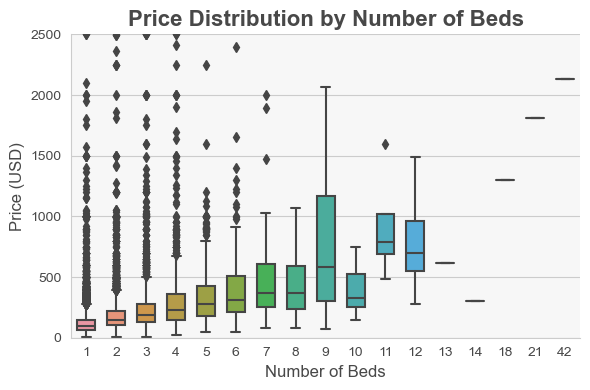

In [100]:
# Airbnb brand red and soft neutrals
airbnb_palette = sns.color_palette("Spectral", as_cmap=False)

# Plot
plt.figure(figsize=(6, 4))
sns.set_style("whitegrid")
sns.set_palette(airbnb_palette)

sns.boxplot(
    data=aircopy,
    x="beds",
    y="price",
    showfliers=True,
    width=0.6
)

# Styling
plt.title("Price Distribution by Number of Beds", fontsize=16, fontweight='bold', color='#484848')
plt.xlabel("Number of Beds", fontsize=12, color='#484848')
plt.ylabel("Price (USD)", fontsize=12, color='#484848')
plt.xticks(fontsize=10, color='#484848')
plt.yticks(fontsize=10, color='#484848')
plt.ylim(0, 2500)
sns.despine()

# Background
plt.gca().set_facecolor('#F7F7F7')
plt.gcf().set_facecolor('white')

# Save
plt.tight_layout()
plt.savefig("../plots/airbnb_boxplot_price_beds.png", dpi=300)

plt.show()

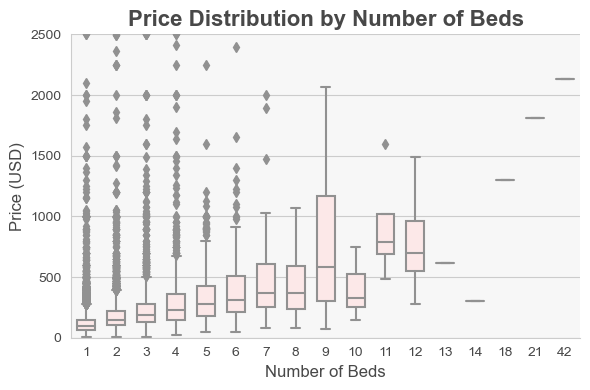

In [111]:
# Airbnb colors
airbnb_coral = '#FFE5E5'
background_gray = '#F7F7F7'
text_gray = '#484848'

# Plot
plt.figure(figsize=(6, 4))
sns.set_style("whitegrid")

# Set single color for all boxplots
sns.boxplot(
    data=aircopy,
    x="beds",
    y="price",
    showfliers=True,
    width=0.6,
    color=airbnb_coral
)

# Styling
plt.title("Price Distribution by Number of Beds", fontsize=16, fontweight='bold', color=text_gray)
plt.xlabel("Number of Beds", fontsize=12, color=text_gray)
plt.ylabel("Price (USD)", fontsize=12, color=text_gray)
plt.xticks(fontsize=10, color=text_gray)
plt.yticks(fontsize=10, color=text_gray)
plt.ylim(0, 2500)
sns.despine()

# Background
plt.gca().set_facecolor(background_gray)
plt.gcf().set_facecolor('white')

# Save
plt.tight_layout()
plt.savefig("../plots/airbnb_boxplot_price_beds.png", dpi=300)

plt.show()

#### Scatterplot of predicted price vs actual price

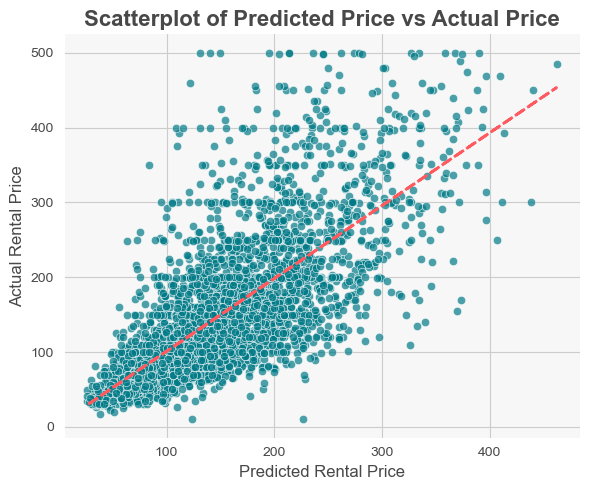

In [43]:
# Airbnb-inspired color palette
airbnb_red = '#FF5A5F'
background_gray = '#F7F7F7'
text_gray = '#484848'

# Example best-fit line (replace with actual regression if available)
line = np.polyfit(y_pred, y_test, 1)
line_fn = np.poly1d(line)

# Set style
plt.style.use('default')
sns.set_style("whitegrid")
plt.rcParams.update({
    'axes.facecolor': background_gray,
    'axes.edgecolor': 'white',
    'axes.titleweight': 'bold',
    'axes.titlesize': 16,
    'axes.labelsize': 12,
    'font.family': 'Arial',  # or 'Nunito', 'Arial', etc.
    'xtick.color': text_gray,
    'ytick.color': text_gray,
    'axes.labelcolor': text_gray,
    'figure.facecolor': 'white'
})

# Plot
plt.figure(figsize=(6, 5))
plt.scatter(y_pred, y_test, color='#007A87', alpha=0.7, edgecolors='white', linewidth=0.5)
plt.plot(y_pred, line_fn(y_pred), color=airbnb_red, linewidth=2, linestyle='--')

plt.title('Scatterplot of Predicted Price vs Actual Price', color=text_gray)
plt.xlabel('Predicted Rental Price')
plt.ylabel('Actual Rental Price')


# Clean up ticks
plt.tick_params(axis='both', which='major', labelsize=10)
sns.despine()
plt.tight_layout()

# Save plot
plt.savefig("../plots/styled_scatterplot_predvstest.png", dpi=300)

plt.show()

#### Scatterplot of predicted price vs actual price (zoomed in)

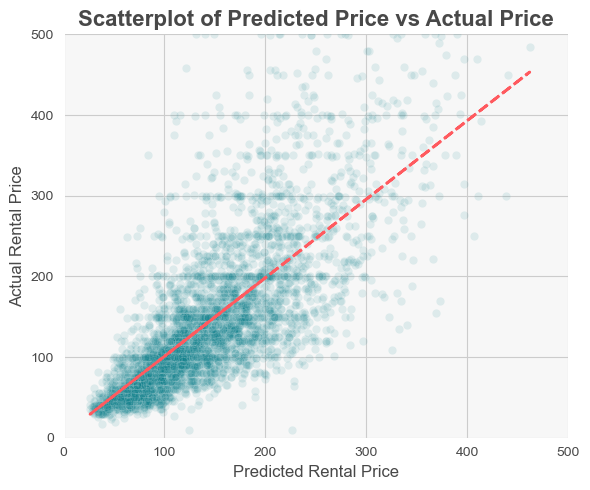

In [47]:
# Airbnb-inspired color palette
airbnb_red = '#FF5A5F'
background_gray = '#F7F7F7'
text_gray = '#484848'

# Example best-fit line (replace with actual regression if available)
line = np.polyfit(y_pred, y_test, 1)
line_fn = np.poly1d(line)

# Set style
plt.style.use('default')
sns.set_style("whitegrid")
plt.rcParams.update({
    'axes.facecolor': background_gray,
    'axes.edgecolor': 'white',
    'axes.titleweight': 'bold',
    'axes.titlesize': 16,
    'axes.labelsize': 12,
    'font.family': 'Arial',  # or 'Nunito', 'Arial', etc.
    'xtick.color': text_gray,
    'ytick.color': text_gray,
    'axes.labelcolor': text_gray,
    'figure.facecolor': 'white'
})

# Plot
plt.figure(figsize=(6, 5))
plt.scatter(y_pred, y_test, color='#007A87', alpha=0.1, edgecolors='white', linewidth=0.5)
plt.plot(y_pred, line_fn(y_pred), color=airbnb_red, linewidth=2, linestyle='--')

plt.title('Scatterplot of Predicted Price vs Actual Price', color=text_gray)
plt.xlabel('Predicted Rental Price')
plt.ylabel('Actual Rental Price')

# Zoom in: set axis limits
plt.xlim(0, 500)
plt.ylim(0, 500)

# Clean up ticks
plt.tick_params(axis='both', which='major', labelsize=10)
sns.despine()
plt.tight_layout()

# Save plot
plt.savefig("../plots/styled_scatterplot_predvstest2.png", dpi=300)

plt.show()

_________________

<a id="4"></a>
## Conclusion

In this analysis of the Airbnb NYC Listings 2024, the data was cleaned, preprocessed, and modeled with a linear regression. The features were engineered to fix inconsistencies, such as fixing the number of bedrooms listed as "Studio" to 0, to match with the numberic format of the rest of the column. Other features were engineered to assist with the modeling. An example is the case of the neighbourhood. Since it had over 200 columns, it was not a good candidate for dummy variables, so instead, the column was imputed with the average price of the neighbourhood. Binning was also used in preprocessing, as the rating column included many values of "No rating" and "New," after binning the numeric ratings, the whole column was ready to be One Hot Encoded. 

After preprocessing, the dataset was ready for modeling. In an initial modeling, Linear Regression was used as the baseline model. The initial model performed to poor results, with a train score of 0.01, and test score of 0.12. Essentially only being able to exlain about 12% of the price variance. To improve model performance and tuning, a Pipeline and GridsearchCV were setup. With the help of the Gridsearch hyperparameter tuning, the StandardScaler was chosen over no scaler, and PCA component number of 10 was selected. This resulted in a train score of 0.008 and test score of 0.13, with an improved ability to explain the price variance to 13%.

The linear regression model performed poorly and was likely negatively biased by the extreme outliers. Sci-kit Learn's default linear regression score uses $R^2$. Which heavily punishes the model for outliers as the errors are squared, magnifying the already extreme outliers in the dataset (ie. there are price outliers of \\$10k per night compared to the average range of \\$200-\\$300). To handle this, the outliers were removed to help the model focus on predicting prices less than \\$500 (leaving out only 3.52% of the outlier listings).

Additional models such as Ridge, Lasso, and Elastic Net were considered. Elastic Net with a built-in combination of Ridge and Lasso regularization could help with handling outliers as they shrink the outlier coefficients, effectively decreasing the outliers' effect on the model. Ultimately non-linear models such as Random Forest and XGBoost were modeled on the dataset, chosen for their ability to work well with outliers and non-linear independent features. 

The three models, Linear Regression (R^2=0.13, RMSE=284.44, MAE=98.53), XGBoost(R^2=-5.87, RMSE=800.15, MAE=93.94), and Random Forest (R^2=-0.06, RMSE=315.01, MAE=91.52) did not perform well in the initial run and was heavily punished for the outliers and had large RMSE scores. After limiting the price to \\$500, the models performed much better; Linear Regression (R^2=0.39, RMSE=71.50, MAE=51.32), XGBoost(R^2=0.52, RMSE=62.91, MAE=43.58), and Random Forest (R^2=0.52, RMSE=63.61, MAE=43.72). Their RMSE scores also dropped significantly, indicating that the model is less severely punished for the outliers (as large outlier errors can be magnified by the squaring). 

Of the three models, XGBoost was chosen for a final model tuning. Although XGBoost and Random Forest had similar scores, XGBoost had slightly better scores, performed much quicker, and had a closer train to test score, indicating less overfitting. The final model of XGBoost (R^2=0.55, RMSE=61.37, MAE=42.19) improved significantly from the initial models, and could explain 55% of the variance in the target variable, and had a predicted score that was on average within a $42 range of the actual listing price. The price segmentation proved to be an effective strategy in a business context such as predicting Airbnb Listing Prices, as most hosts would not like their one to two bedroom place priced with the same model as a one for pricing a 10-bedroom mansion. This limiting of the price allowed the model to have more price consistency, be less affected by random outliers, and focus more on the features that are important to the listings within its price range. 